In [1]:
#NOTE: use paimg1 env, the retccl one has package issue with torchvision
import sys
import os
import numpy as np
import openslide
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
from pathlib import Path
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords, get_map_startend
from Utils import get_downsample_factor
from Utils import minmax_normalize, count_label
from Utils import log_message, set_seed
from Utils import simple_line_plot
from cluster_utils import get_cluster_data, get_cluster_label, get_updated_feature
from Eval import compute_performance, plot_LOSS, compute_performance_each_label, get_attention_and_tileinfo
from train_utils import pull_tiles, get_feature_label_array_dynamic
from train_utils import ModelReadyData_diffdim, convert_to_dict, prediction
from Model import Mutation_MIL_MT
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
####################################
######      USERINPUT       ########
####################################
SELECTED_LABEL = ["AR","MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
SELECTED_FEATURE = [str(i) for i in range(0,2048)] + ['TUMOR_PIXEL_PERC']
TUMOR_FRAC_THRES = 0
TRAIN_SAMPLE_SIZE = "ALLTUMORTILES"
TRAIN_OVERLAP = 100
TEST_OVERLAP = 0
SELECTED_FOLD = 0
CLUSTER_ALG = 'KMEAN'
N_CLUSTERS = 4
CLUSTER_DIST = 'L2'

##################
###### DIR  ######
##################
proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/'
wsi_path = proj_dir + '/data/OPX/'
label_path = proj_dir + 'data/MutationCalls/'
train_tile_path = proj_dir + 'intermediate_data/cancer_prediction_results110224/IMSIZE250_OL' + str(TRAIN_OVERLAP) + '/'
test_tile_path =  proj_dir + 'intermediate_data/cancer_prediction_results110224/IMSIZE250_OL' + str(TEST_OVERLAP) + '/'
feature_name = 'features_alltiles_retccl'
data_info_path = proj_dir + 'intermediate_data/model_ready_data/' +'MAX_SS'+ str(TRAIN_SAMPLE_SIZE)  + '_TrainOL' + str(TRAIN_OVERLAP) +  '_TestOL' + str(TEST_OVERLAP) + "/split_fold" + str(SELECTED_FOLD) + "/init_data_info/"

################################################
#Create output dir
################################################
outpath = proj_dir + 'intermediate_data/model_ready_data/' +'MAX_SS'+ str(TRAIN_SAMPLE_SIZE)  + '_TrainOL' + str(TRAIN_OVERLAP) +  '_TestOL' + str(TEST_OVERLAP) + "/split_fold" + str(SELECTED_FOLD)
outdir0 =  os.path.join(outpath,"clusters")
create_dir_if_not_exists(outdir0)
outdir =   os.path.join(outpath, "clusters", CLUSTER_ALG)
create_dir_if_not_exists(outdir)

##################
#Select GPU
##################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
set_seed(0)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/model_ready_data/MAX_SSALLTUMORTILES_TrainOL100_TestOL0/split_fold0/clusters' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/model_ready_data/MAX_SSALLTUMORTILES_TrainOL100_TestOL0/split_fold0/clusters/KMEAN' created.
cuda:0


In [3]:
############################################################################################################
#Get features and labels
############################################################################################################
train_feature = torch.load(data_info_path + 'train_feature.pth')
test_feature = torch.load(data_info_path + 'test_feature.pth')
val_feature = torch.load(data_info_path + 'val_feature.pth')

In [4]:
train_label = torch.load(data_info_path + 'train_label.pth')
test_label = torch.load(data_info_path + 'test_label.pth')
val_label = torch.load(data_info_path + 'val_label.pth')

train_ids = torch.load(data_info_path + 'train_ids.pth')
test_ids = torch.load(data_info_path + 'test_ids.pth')
val_ids = torch.load(data_info_path + 'val_ids.pth')

In [5]:
################################################
#Clustering
################################################
#Get data for clustering
train_feature_df = get_cluster_data(train_feature, train_label, train_ids, SELECTED_LABEL)
test_feature_df = get_cluster_data(test_feature, test_label, test_ids, SELECTED_LABEL)
valid_feature_df = get_cluster_data(val_feature, val_label, val_ids, SELECTED_LABEL)

In [6]:
# Perform PCA
cluster_feature_name = range(0,2048)
cluster_feature = train_feature_df[cluster_feature_name]
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cluster_feature)
explained_variance = pca.explained_variance_
print("Explained variance by each component:", explained_variance)

Explained variance by each component: [0.32289413 0.23200851]


1
2
3
4
5
6
7
8
9
10


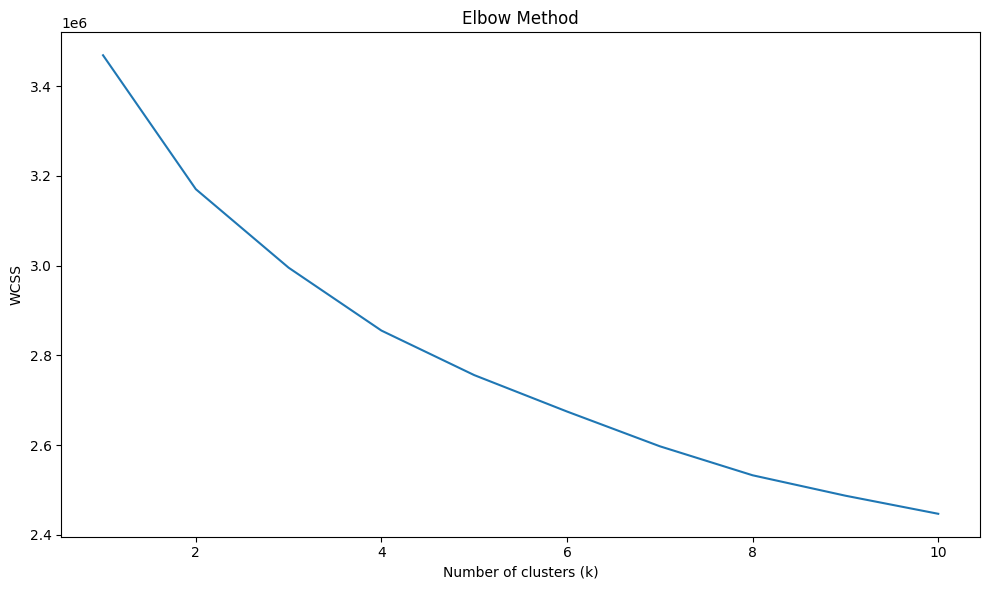

In [7]:
# Calculate WCSS for different values of k
wcss = []
for i in range(1, 11):
    print(i)
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(cluster_feature)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
simple_line_plot(range(1, 11), wcss, 'Number of clusters (k)', 'WCSS', 'Elbow Method', outdir + "/Elbow_Ks.png")

In [8]:
# Perform K-means clustering
kmeans = KMeans(n_clusters= N_CLUSTERS)
kmeans.fit(cluster_feature)

# Get cluster centers and labels
centers = kmeans.cluster_centers_
cluster_labels_train = kmeans.labels_

In [9]:
# Plot the data points and cluster centers with cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels_train, cmap='viridis',alpha=0.6, s = 0.001)
for i, center in enumerate(centers):
    plt.scatter(center[0], center[1], c='red', marker=f'${i}$', s=200)  # Use cluster label as marker

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering for Tile Embeddings on PCs')
plt.grid(True)
plt.savefig(outdir  + '/original_cluster_scatter.png')
plt.close()

In [14]:
#Get Cluster labels
cluster_labels_test = get_cluster_label(test_feature_df, centers, cluster_feature_name)
cluster_labels_val = get_cluster_label(valid_feature_df, centers, cluster_feature_name)

#add cluster label to df
train_feature_df['Cluster'] = cluster_labels_train
test_feature_df['Cluster'] = cluster_labels_test
valid_feature_df['Cluster'] = cluster_labels_val

#Get updated feature
updated_feature_names= list(range(0,2048)) + ['TUMOR_PIXEL_PERC','Cluster']
updated_train_feature = get_updated_feature(train_feature_df, train_ids, updated_feature_names)
updated_test_feature = get_updated_feature(test_feature_df, test_ids, updated_feature_names)
updated_val_feature = get_updated_feature(valid_feature_df, val_ids, updated_feature_names)


torch.save(updated_train_feature, outdir + '/updated_train_feature' + "_NCLUSTER_" + str(N_CLUSTERS) +  "_DISTMETRIC_" + CLUSTER_DIST + '.pth')
torch.save(updated_test_feature,  outdir + '/updated_test_feature'  + "_NCLUSTER_" + str(N_CLUSTERS)+ "_DISTMETRIC_" + CLUSTER_DIST + '.pth')
torch.save(updated_val_feature,   outdir + '/updated_val_feature' + "_NCLUSTER_" + str(N_CLUSTERS)+ "_DISTMETRIC_" + CLUSTER_DIST + '.pth')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
0
10
20
30
0
